# Explore the input data
We do some data exploration for the autoencoder. We
- Check the unique values of the stick data.
- We check the frequency that the buttons are pressed.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchsummary import summary
from torch.cuda.amp import autocast, GradScaler

import numpy as np
import pandas as pd
import gzip
import pickle
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import gc
import time
import random
import matplotlib.pyplot as plt


import sys
sys.path.append('..')
# from slp_package.slp_functions import create_merged_game_data_df
from slp_package.input_dataset import InputDataSet
import slp_package.pytorch_functions as slp_pytorch_functions

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using CUDA
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

### Check the unique values of the stick data
Here we see that the analog sticks take values between $[-1, -0.2875]\cup\{0\}\cup[0.2875, 1]$ in increments of $.0125$. We load a single file and check the unique values of the stick data.

In [ ]:
path = "/workspace/melee_project_data/input_np/mango/FALCO/72a00ff5-b2a2-4afa-9b63-9523feaf9beb.npy.gz"

with gzip.open(path, 'rb') as f:
            segment = np.load(f)

non_zero = segment[0] != 0

np.unique(segment[0,:])

array([-1.    , -0.9875, -0.975 , -0.9625, -0.95  , -0.9375, -0.925 ,
       -0.9125, -0.9   , -0.8875, -0.875 , -0.8625, -0.85  , -0.8375,
       -0.825 , -0.8125, -0.8   , -0.7875, -0.775 , -0.7625, -0.75  ,
       -0.7375, -0.725 , -0.7125, -0.7   , -0.6875, -0.675 , -0.6625,
       -0.65  , -0.6375, -0.625 , -0.6125, -0.6   , -0.5875, -0.575 ,
       -0.5625, -0.55  , -0.5375, -0.525 , -0.5125, -0.5   , -0.4875,
       -0.475 , -0.4625, -0.45  , -0.4375, -0.425 , -0.4125, -0.4   ,
       -0.3875, -0.375 , -0.3625, -0.35  , -0.3375, -0.325 , -0.3125,
       -0.3   , -0.2875,  0.    ,  0.2875,  0.3   ,  0.3125,  0.325 ,
        0.3375,  0.35  ,  0.3625,  0.375 ,  0.3875,  0.4   ,  0.4125,
        0.425 ,  0.4375,  0.45  ,  0.4625,  0.475 ,  0.4875,  0.5   ,
        0.5125,  0.525 ,  0.5375,  0.55  ,  0.5625,  0.575 ,  0.5875,
        0.6   ,  0.6125,  0.625 ,  0.6375,  0.65  ,  0.6625,  0.675 ,
        0.6875,  0.7   ,  0.7125,  0.725 ,  0.7375,  0.75  ,  0.7625,
        0.775 ,  0.7

### Check the frequency that the buttons are pressed
We need to load a large sample of the input data so that we get a good estimate of the frequency that the buttons are pressed.

In [3]:
source_data = ['ranked','public','mango']

general_features = {
    'stage_name': ['FOUNTAIN_OF_DREAMS','FINAL_DESTINATION','BATTLEFIELD','YOSHIS_STORY','POKEMON_STADIUM','DREAMLAND'],
    'num_players': [2],
    'conclusive': [True],
}
player_features = {
    # 'netplay_code': ['MANG#0'],
    # 'character_name': ['YOSHI'],
    # 'character_name': ['FOX', 'FALCO', 'MARTH', 'CAPTAIN_FALCON', 'SHEIK'],
    # 'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'MARIO', 'PEACH', 'ROY', 'LUIGI', 'YOUNG_LINK', 'DONKEY_KONG', 'PICHU', 'KIRBY'],
    'character_name': ['FOX', 'CAPTAIN_FALCON', 'SHEIK', 'FALCO', 'GAME_AND_WATCH', 'MARTH', 'LINK', 'ICE_CLIMBERS', 'SAMUS', 'GANONDORF', 'BOWSER', 'MEWTWO', 'YOSHI', 'PIKACHU', 'JIGGLYPUFF', 'NESS', 'DR_MARIO', 'PEACH', 'LUIGI', 'DONKEY_KONG'],
    'type_name': ['HUMAN']
    
}
opposing_player_features = {
    # 'character_name': ['MARTH'],
    # 'netplay_code': ['KOD#0', 'ZAIN#0']
    'type_name': ['HUMAN']
}
label_info = {
    'source': ['player'], # Can be 'general', 'player
    # 'feature': ['netplay_code']
    'feature': ['character_name']
}

In [4]:
dataset = InputDataSet(source_data, general_features, player_features, opposing_player_features, label_info)

df = dataset.dataset

df.head()

/workspace/slp_jaspar/autoencoder_revised/../slp_package/input_dataset.py:113: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  processed_df = pd.concat([player_1_df, player_2_df], ignore_index=True)


,stage_name,num_players,conclusive,player_character_name,player_type_name,opposing_player_type_name,player_inputs_np_sub_path,length,labels
0,FINAL_DESTINATION,2,True,FALCO,HUMAN,HUMAN,mango\FALCO\727e819f-8cb3-4c3f-bf0a-ceefa9e41c...,5606,FALCO
1,FINAL_DESTINATION,2,True,FALCO,HUMAN,HUMAN,mango\FALCO\76fe3db5-60de-46bb-8f0d-80d48822a8...,5754,FALCO
2,POKEMON_STADIUM,2,True,MARTH,HUMAN,HUMAN,mango\MARTH\7e6b417f-249d-4629-b6dc-2fe1d95d8f...,6213,MARTH
3,FOUNTAIN_OF_DREAMS,2,True,FOX,HUMAN,HUMAN,mango\FOX\32305eaf-71d8-46e5-a8a1-2c7c890a9baf...,7621,FOX
4,FINAL_DESTINATION,2,True,FALCO,HUMAN,HUMAN,mango\FALCO\a5396c32-6f2c-4b88-8582-f8b875bb55...,7840,FALCO


We sample 10,000 games. The ratio appears as the mean of the sum of the button presess. We use this as the positive weight values in our loss function used to train the autoencoder model.

In [9]:
data_key = { 
    'JSTICK_X':[],
    'JSTICK_Y':[], 
    'CSTICK_X':[], 
    'CSTICK_Y':[],
    'TRIGGER_LOGICAL':[],  
    'Z':[],  
    'A':[],  
    'B':[], 
    'X_or_Y':[],
    'JSTICK_X_LOGICAL':[],
    'JSTICK_Y_LOGICAL':[],
    'CSTICK_X_LOGICAL':[],
    'CSTICK_Y_LOGICAL':[]
}

def load_and_process(path, length, row_sums_dict):
    
    with gzip.open(path, 'rb') as f:
            inputs = np.load(f)
    
    # Transform inputs like the model will
    
    transformed = np.zeros((13, inputs.shape[1]))
    transformed[:9] = inputs
    transformed[5] = (inputs[5] > .5)
    transformed[9:] += (inputs[:4] == 0)

    # Want a new dictionary with each the sum of each row of inputs being added the values of data_key
    row_sums_np = np.sum(np.abs(transformed), axis=1) / length

    # Map each sum to the corresponding key in data_key
    keys = row_sums_dict.keys()
    for index, key in enumerate(keys):
        row_sums_dict[key].append(row_sums_np[index])
    
    row_sums_dict.update(row_sums_dict)
    return 

sample_df = df.sample(n=10_000, random_state=42)

row_sums_dict = data_key.copy()

for i in tqdm(range(sample_df.shape[0])):
    load_and_process('/workspace/melee_project_data/input_np/' + sample_df['player_inputs_np_sub_path'].iloc[i].replace('\\','/'),sample_df['length'].iloc[i],row_sums_dict)

row_sums_df = pd.DataFrame(row_sums_dict)

print('\nFrequency of button presses:', end='')
row_sums_df.describe().loc['mean']


100%|██████████| 10000/10000 [00:08<00:00, 1207.55it/s]


Frequency of button presses:

JSTICK_X            0.469716
JSTICK_Y            0.228981
CSTICK_X            0.023041
CSTICK_Y            0.023443
TRIGGER_LOGICAL     0.169088
Z                   0.008974
A                   0.060946
B                   0.045915
X_or_Y              0.096637
JSTICK_X_LOGICAL    0.458498
JSTICK_Y_LOGICAL    0.687903
CSTICK_X_LOGICAL    0.972654
CSTICK_Y_LOGICAL    0.971676
Name: mean, dtype: float64

In [6]:
list(row_sums_df.mean())

[0.4697157068552351,
 0.22898121753808623,
 0.023041282498833554,
 0.02344324908372379,
 0.16908772957310006,
 0.008974353071937505,
 0.060945588829374495,
 0.04591526858731047,
 0.09663690337362206,
 0.45849791926398437,
 0.6879025510132348,
 0.9726537459234259,
 0.971675825912117]

### Visualize the frequency of the stick inputs
We make a heat map of the 2D stick data to see the distribution. We use a logaritmic scale to see the distribution better. We start by removing the most common value (0,0) and then plot the data. We make a loop that removes the 10 most frequenth bins each time and plot the data. This helps see the distribution of the less common values.

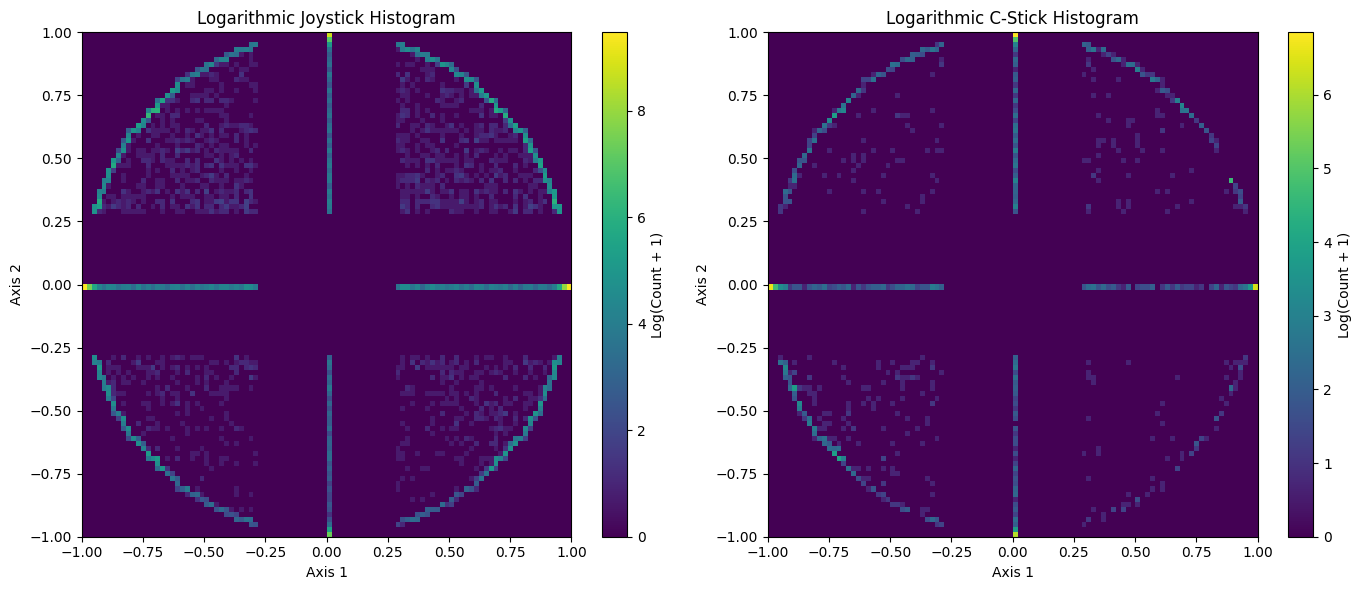

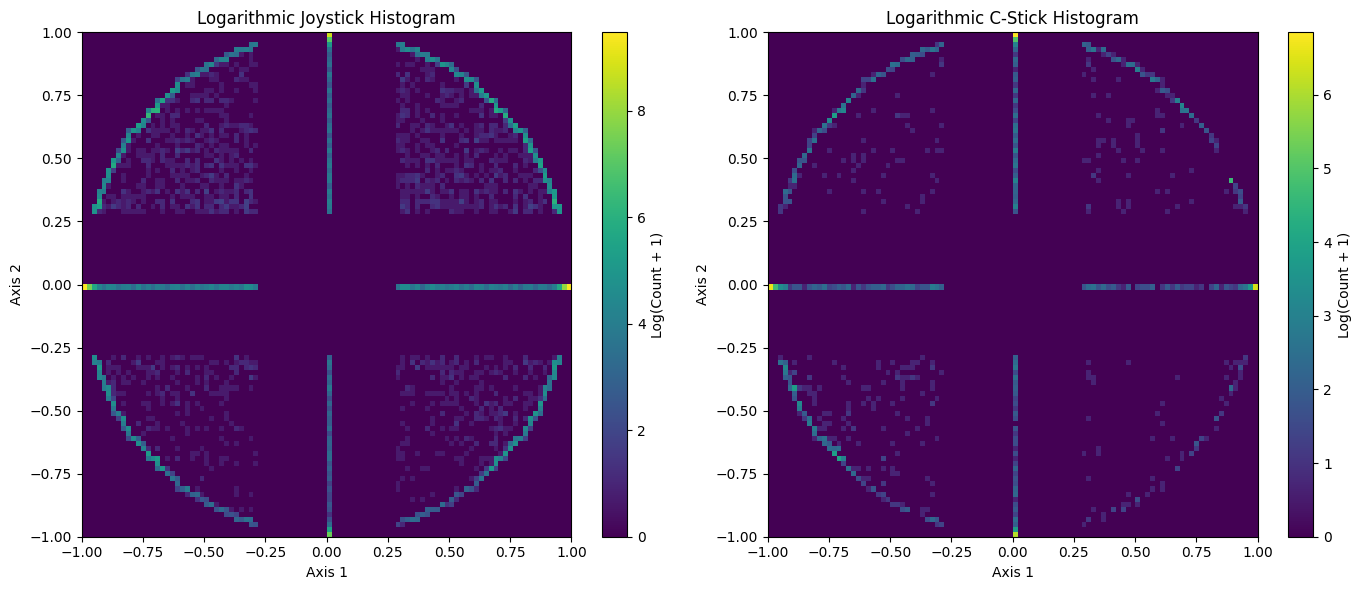

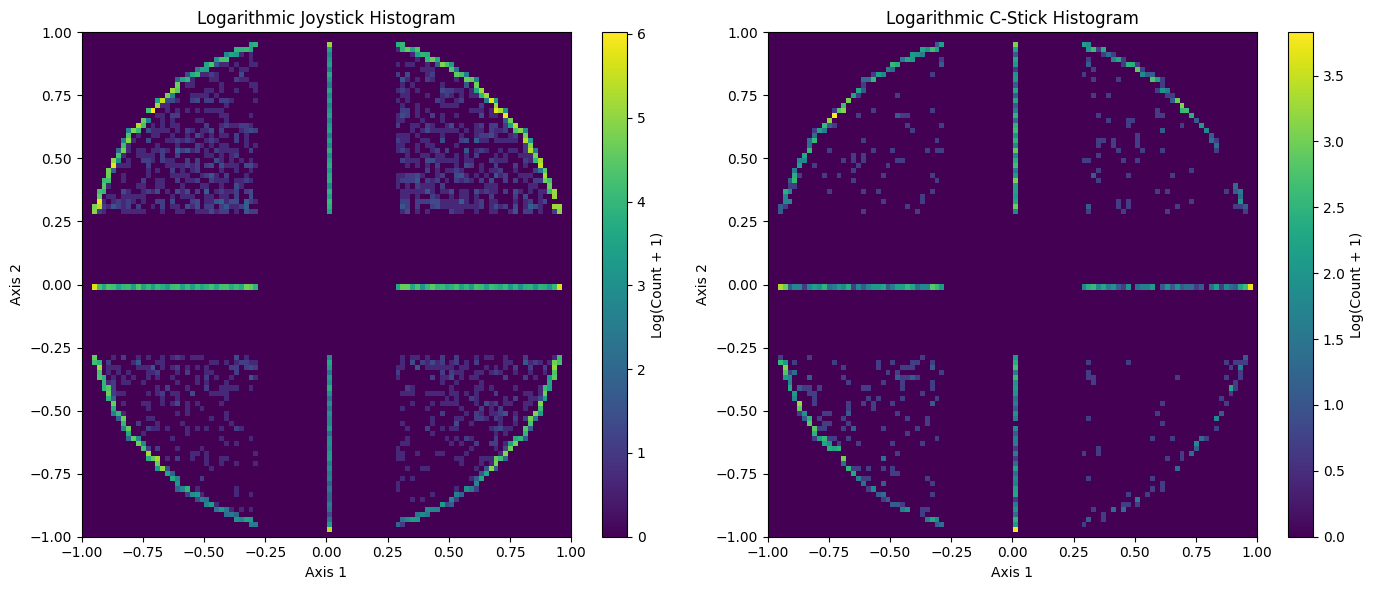

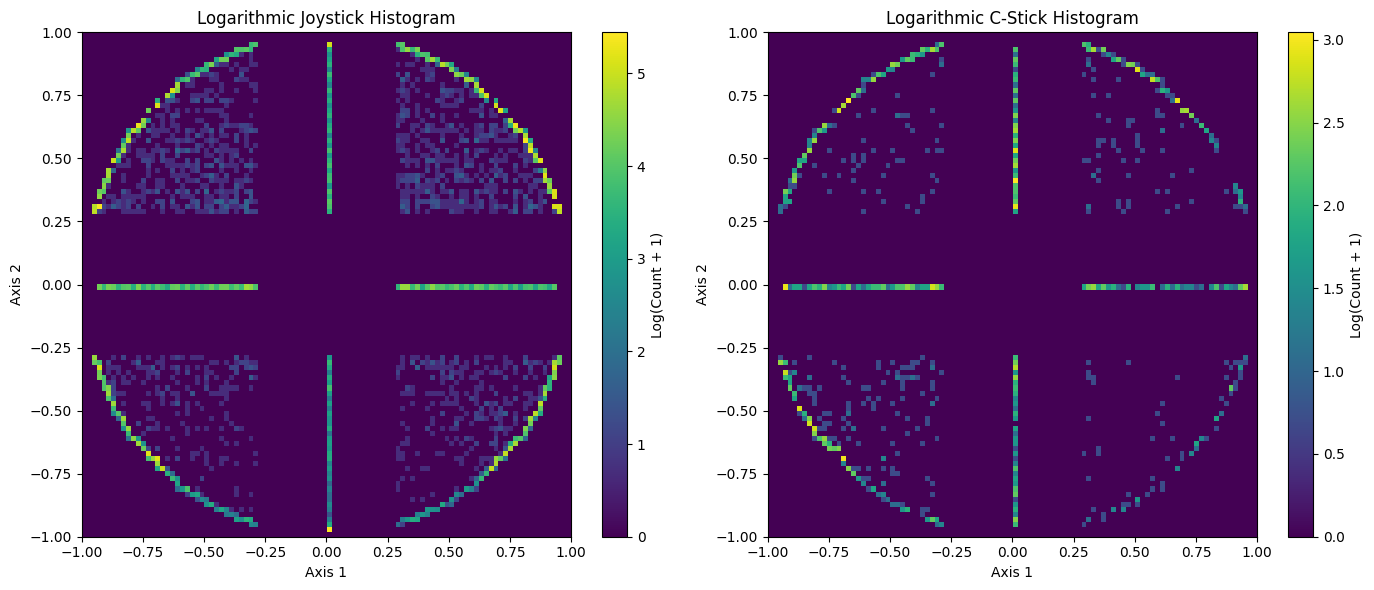

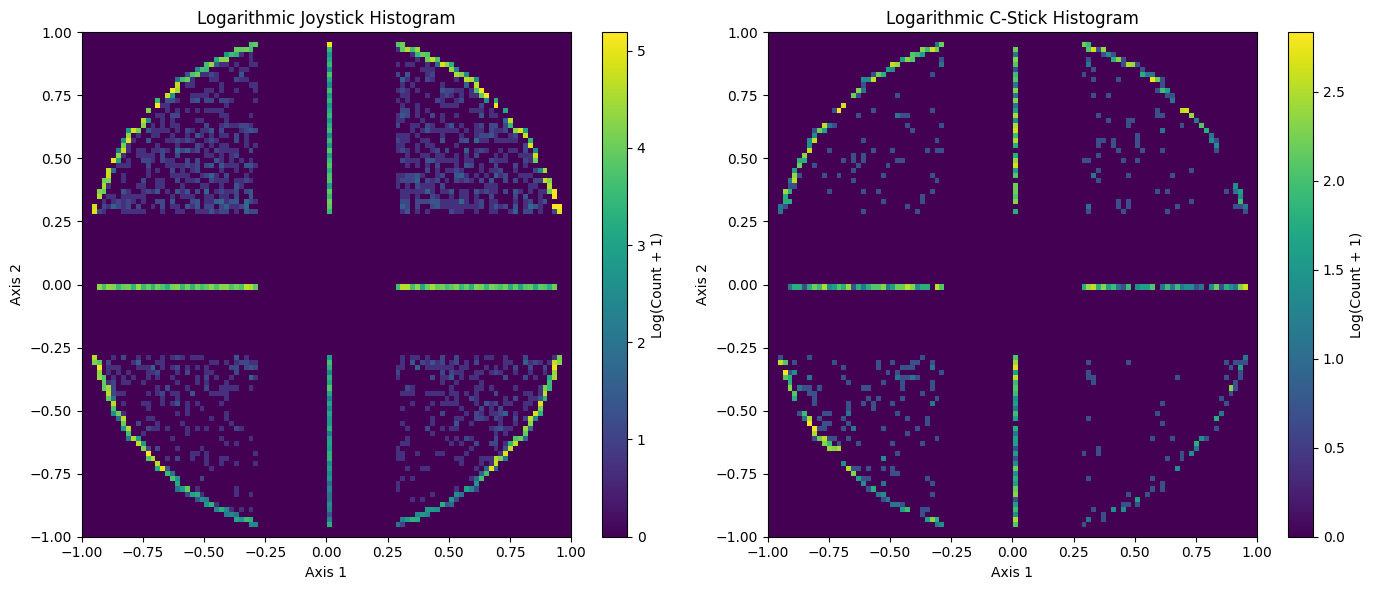

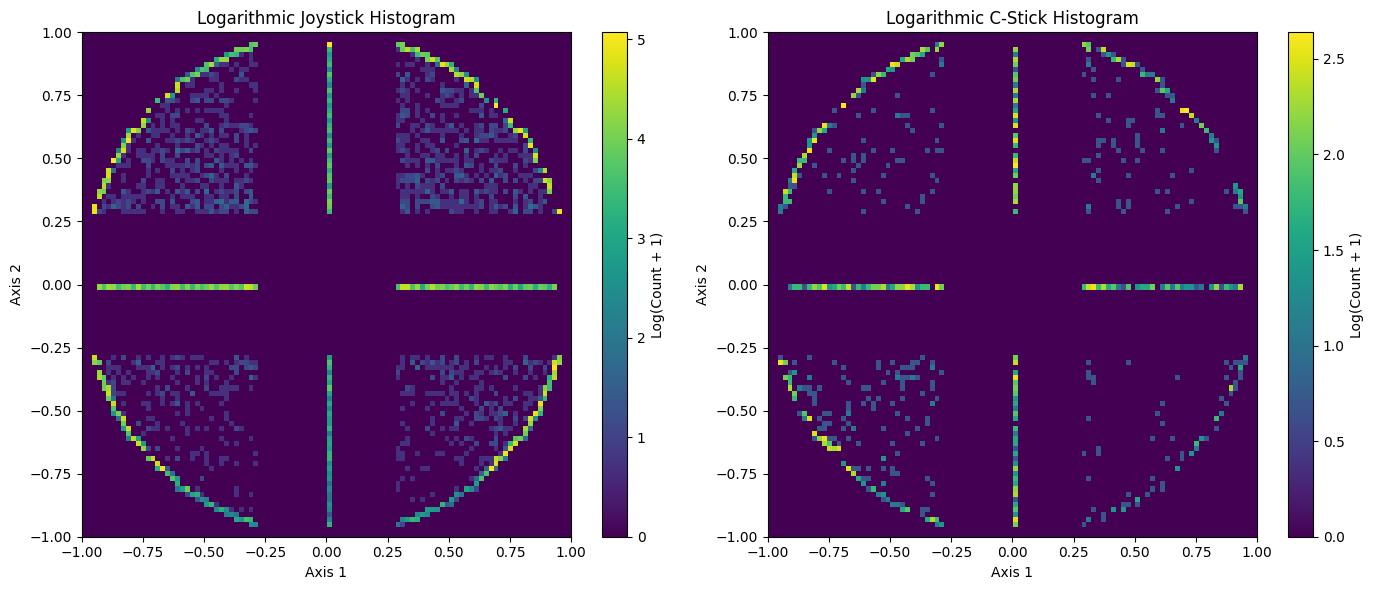

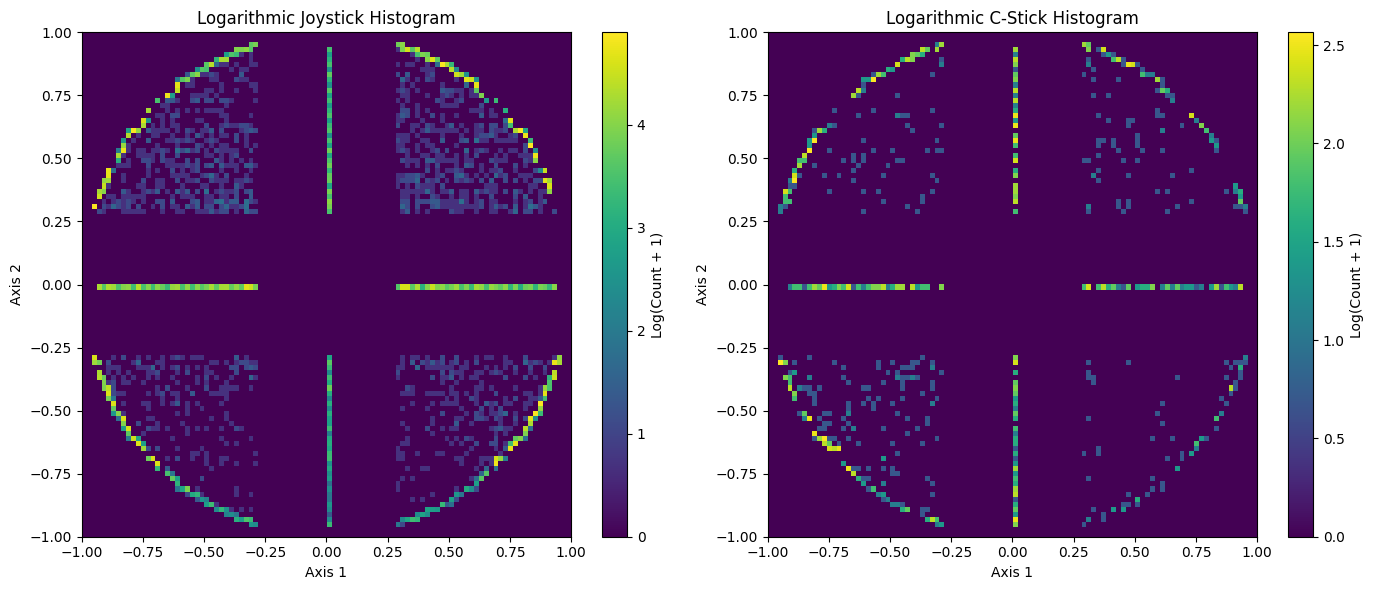

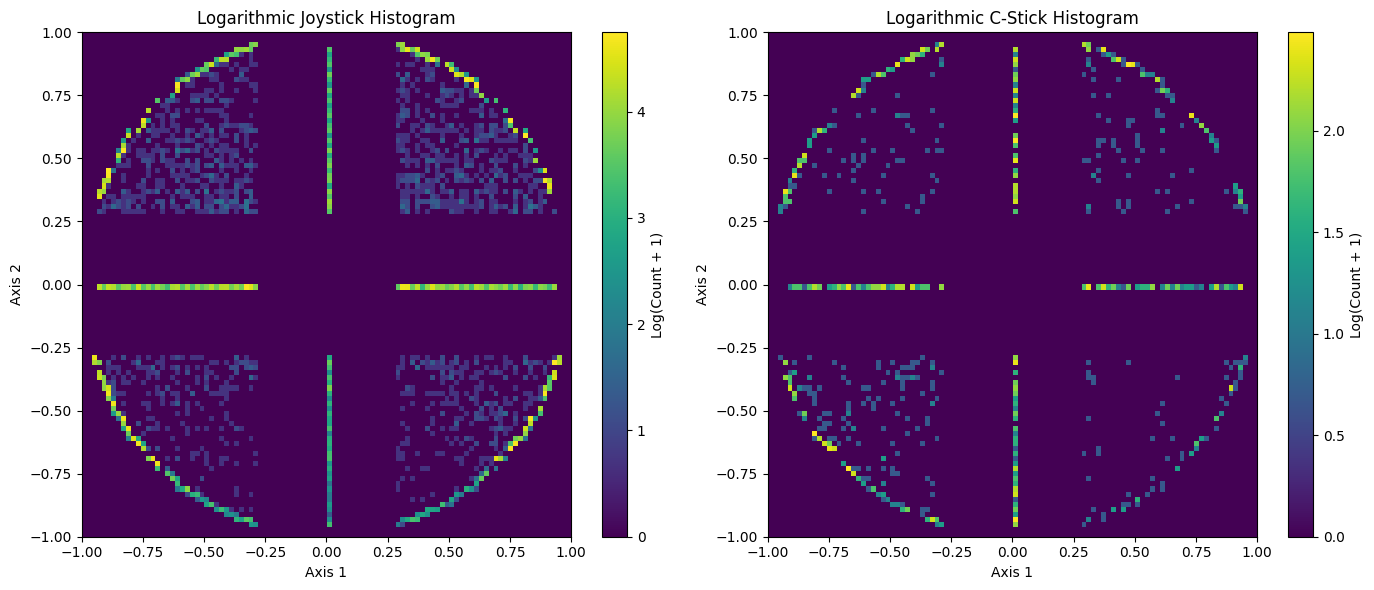

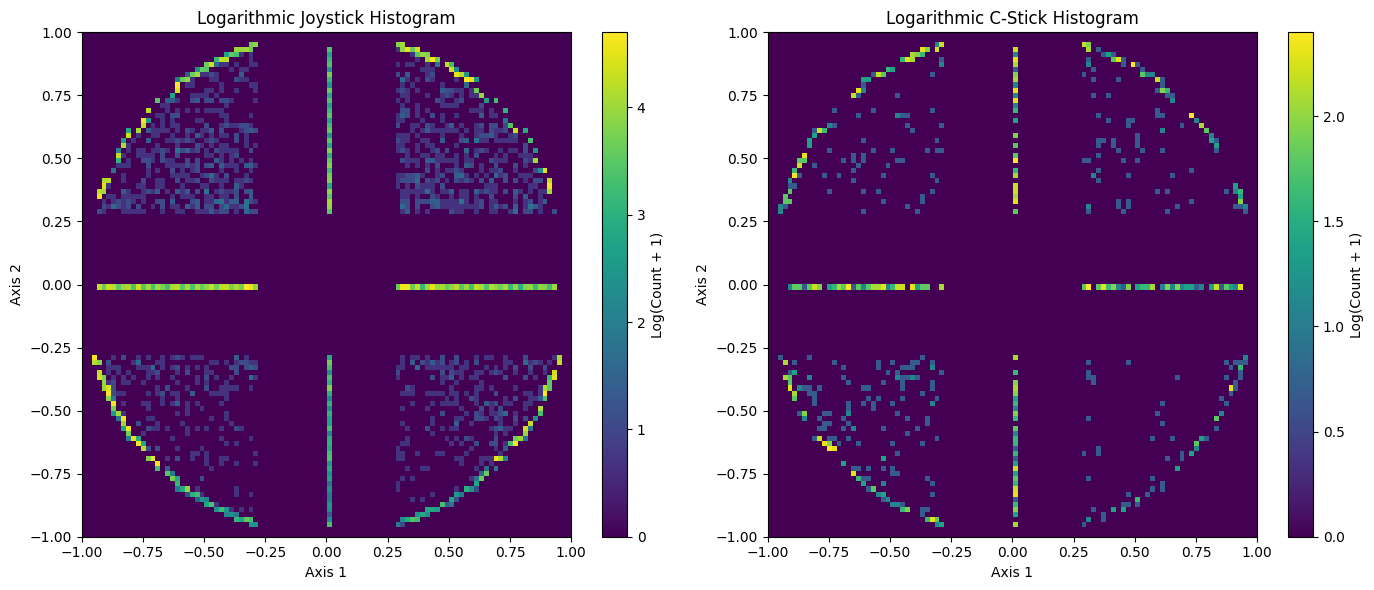

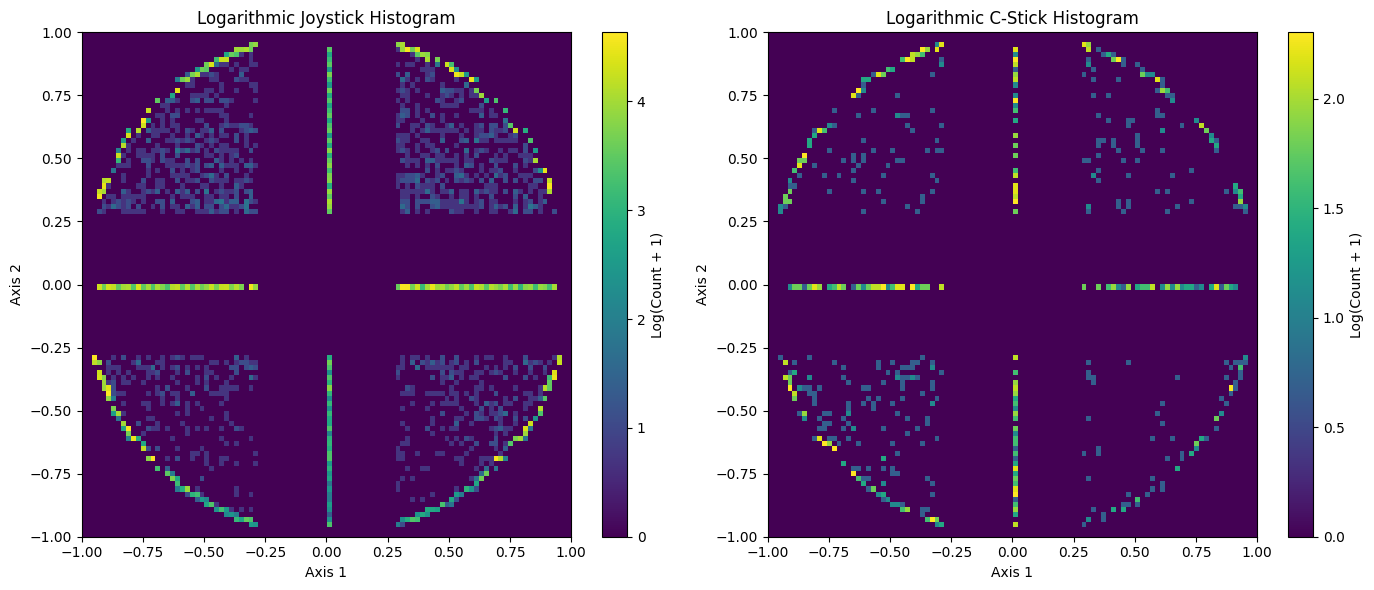

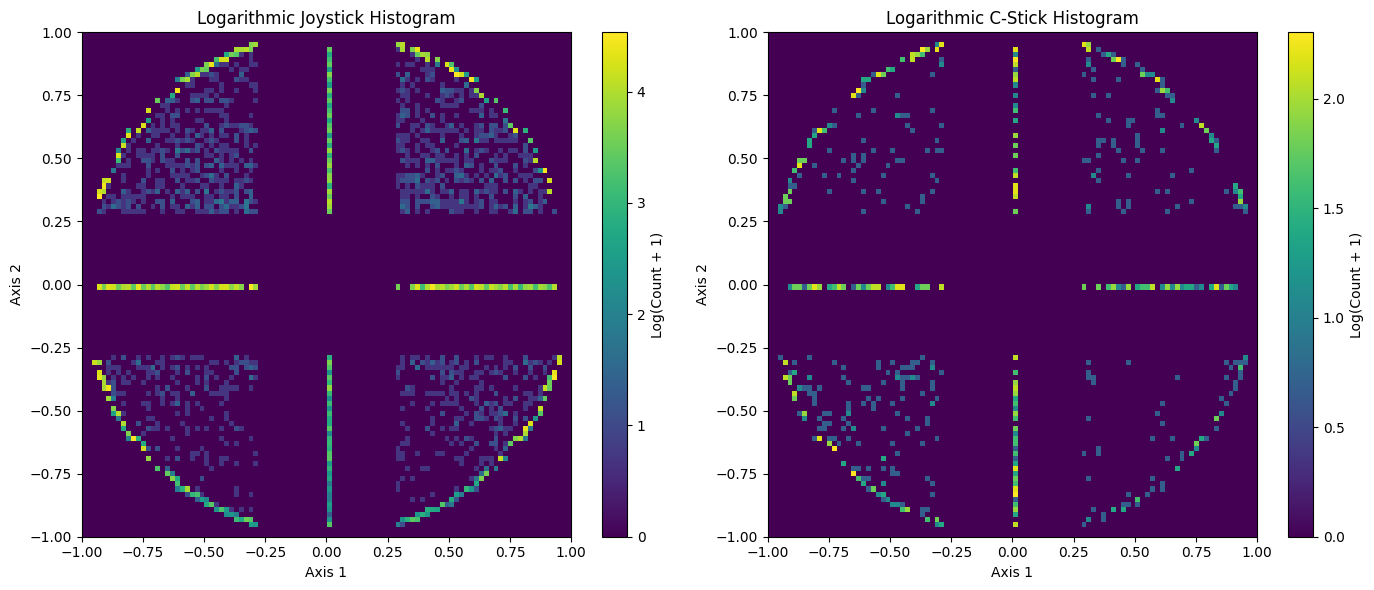

In [28]:


def load_and_update_histogram(path, jstick_histogram, cstick_histogram, nbins):
    with gzip.open(path, 'rb') as f:
        inputs = np.load(f)
    
    # Correcting the shift and scaling logic
    # Shift inputs: adjusting so that positives are reduced and negatives are increased
    # inputs[0:4, :] -= .2875 * (inputs[0:4, :] > 0)
    # inputs[0:4, :] += .2875 * (inputs[0:4, :] < 0)

    # Scale inputs to be between -1 and 1
    # inputs[0:4, :] *= 1.40350877193

    # Update histograms
    j_hist, _, _ = np.histogram2d(inputs[1, :], inputs[0, :], bins=nbins, range=[(-1, 1), (-1, 1)])
    c_hist, _, _ = np.histogram2d(inputs[3, :], inputs[2, :], bins=nbins, range=[(-1, 1), (-1, 1)])
    
    jstick_histogram += j_hist
    cstick_histogram += c_hist

# Sample initialization and usage
sample_df = df.sample(n=1000, random_state=42)
nbins = 100
jstick_histogram = np.zeros((nbins, nbins), dtype=np.float64)
cstick_histogram = np.zeros((nbins, nbins), dtype=np.float64)

# Assuming 'paths' is a list of file paths to process
for i in range(10):
    path = '/workspace/melee_project_data/input_np/' + sample_df['player_inputs_np_sub_path'].iloc[i].replace('\\', '/')
    load_and_update_histogram(path, jstick_histogram, cstick_histogram, nbins)


def remove_populous_bins(histogram, n):
    # Flatten the histogram to work with 1D array of bins
    flat_histogram = histogram.flatten()
    
    # Find the indices of the n most populous bins
    indices_to_remove = np.argpartition(flat_histogram, -n)[-n:]
    
    # Set these bins' values to zero or minimal value
    flat_histogram[indices_to_remove] = 0
    # Optionally, set to the minimal non-zero value found in original histogram
    # min_value = np.min(flat_histogram[np.nonzero(flat_histogram)])
    # flat_histogram[indices_to_remove] = min_value

    # Reshape back to the original histogram shape
    return flat_histogram.reshape(histogram.shape)


def plot_log_histograms(jstick_histogram, cstick_histogram, nbins, n_remove):
    # Remove the n most populous bins
    jstick_histogram = remove_populous_bins(jstick_histogram, n_remove)
    cstick_histogram = remove_populous_bins(cstick_histogram, n_remove)
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Prepare data for logarithmic scale
    log_jstick_histogram = jstick_histogram
    log_cstick_histogram = cstick_histogram
    log_jstick_histogram = np.log(jstick_histogram + 1)  # Add 1 to avoid log(0)
    log_cstick_histogram = np.log(cstick_histogram + 1)  # Add 1 to avoid log(0)

    # Joystick histogram
    im = axs[0].imshow(log_jstick_histogram, interpolation='nearest', origin='upper',
                        extent=[-1, 1, -1, 1], aspect='auto', cmap='viridis')
    axs[0].set_title('Logarithmic Joystick Histogram')
    axs[0].set_xlabel('Axis 1')
    axs[0].set_ylabel('Axis 2')
    plt.colorbar(im, ax=axs[0], label='Log(Count + 1)')

    # C-stick histogram
    im = axs[1].imshow(log_cstick_histogram, interpolation='nearest', origin='upper',
                        extent=[-1, 1, -1, 1], aspect='auto', cmap='viridis')
    axs[1].set_title('Logarithmic C-Stick Histogram')
    axs[1].set_xlabel('Axis 1')
    axs[1].set_ylabel('Axis 2')
    plt.colorbar(im, ax=axs[1], label='Log(Count + 1)')

    plt.tight_layout()
    plt.show()

# Assuming your histograms are ready
nbins = 100
n_remove = 10 # Number of populous bins to remove
# Assuming your histograms are ready
nbins = 100
n_remove = 10 # Number of populous bins to remove

plot_log_histograms(jstick_histogram, cstick_histogram, nbins, 1)

for n in range(0,10):
    plot_log_histograms(jstick_histogram, cstick_histogram, nbins, n * n_remove + 1)


Here we visualize the stick data after the transformation we will use in the autoencoder. We make the values between $[0,1]$ while keeping the bin around 0 the right width. We also make the values between $[0,1]$ for the buttons.

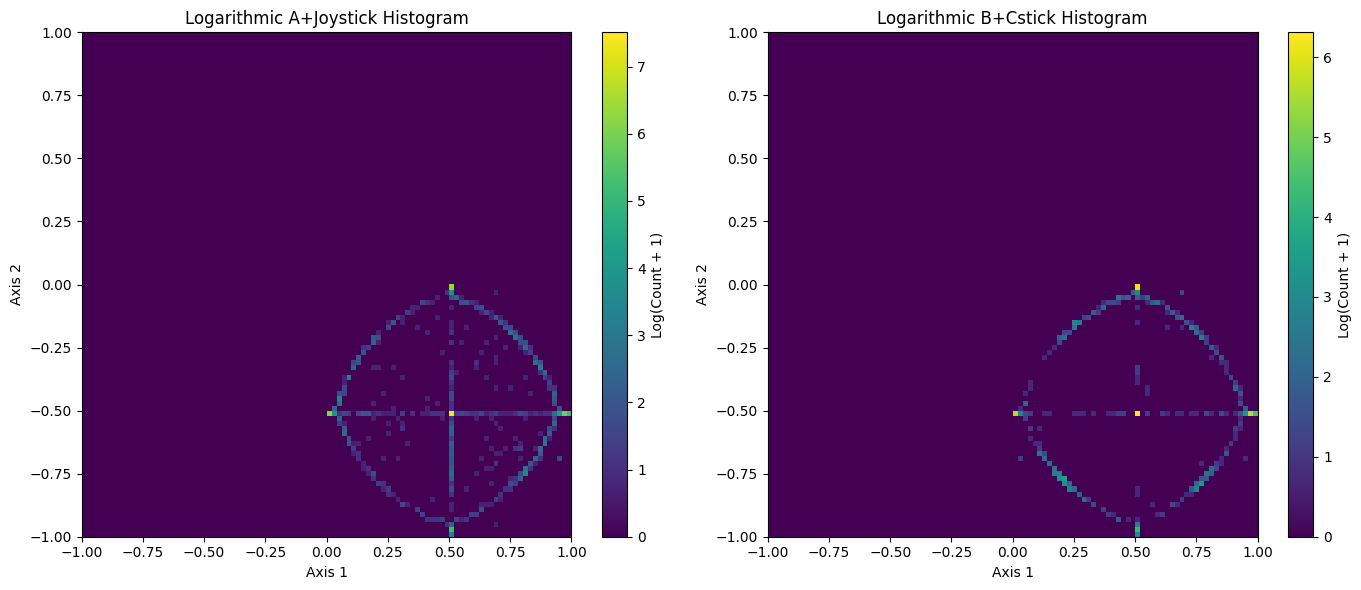

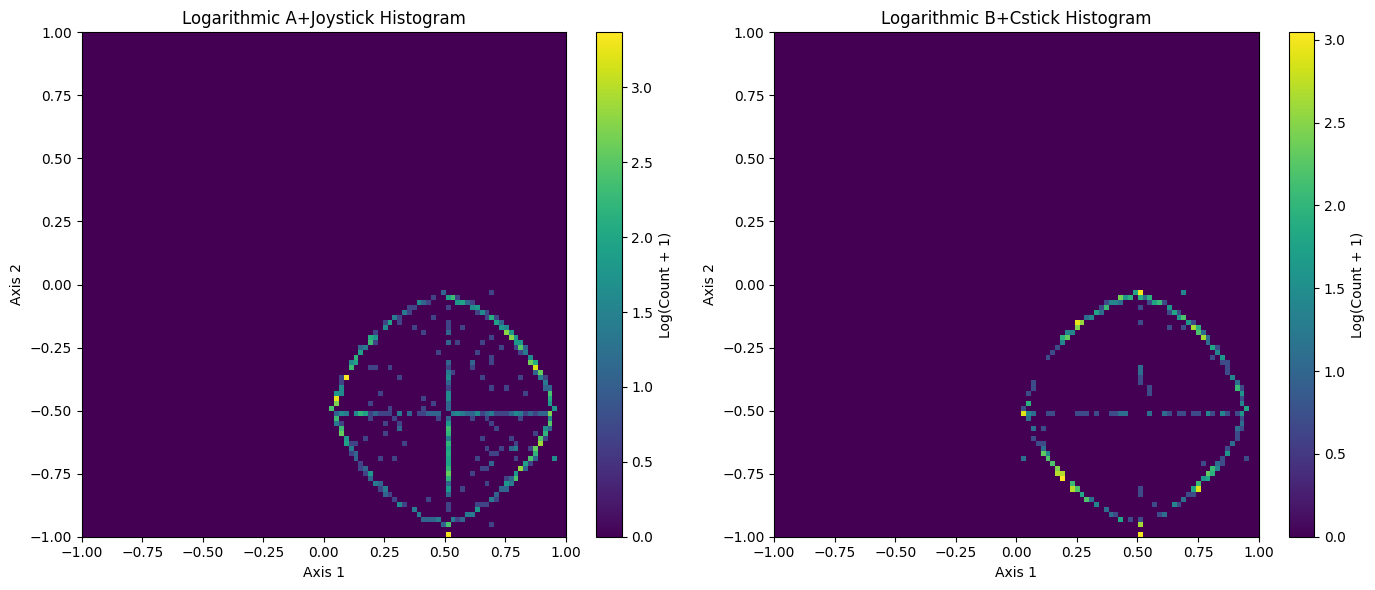

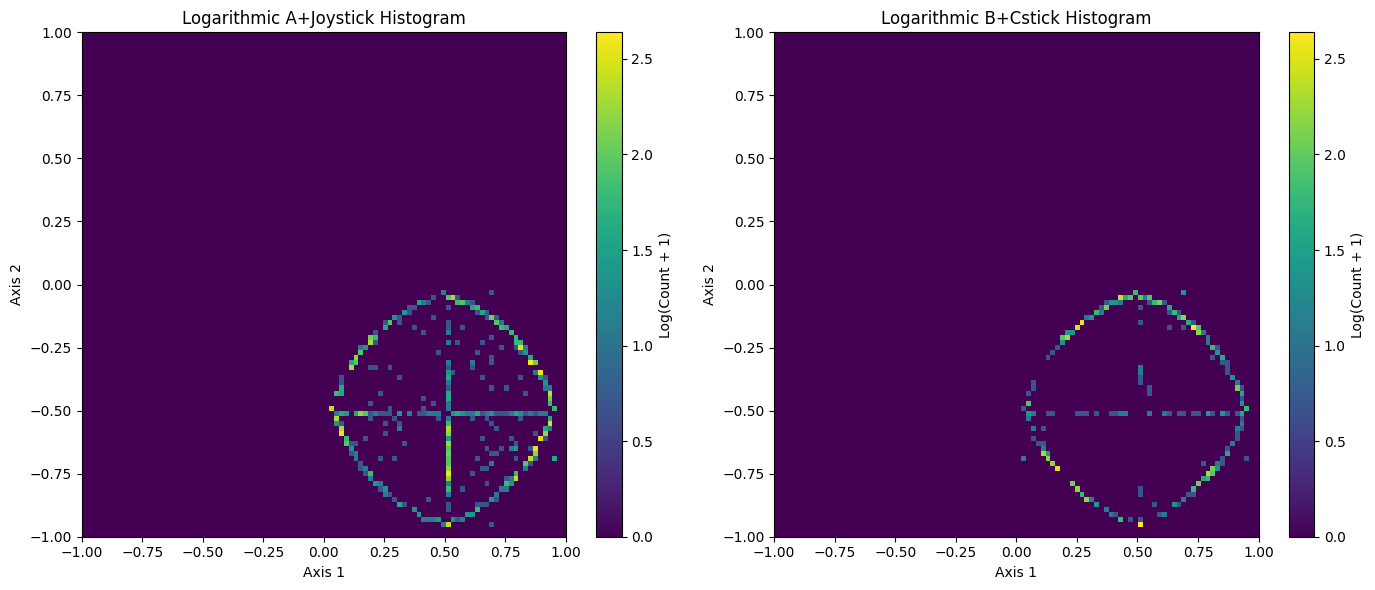

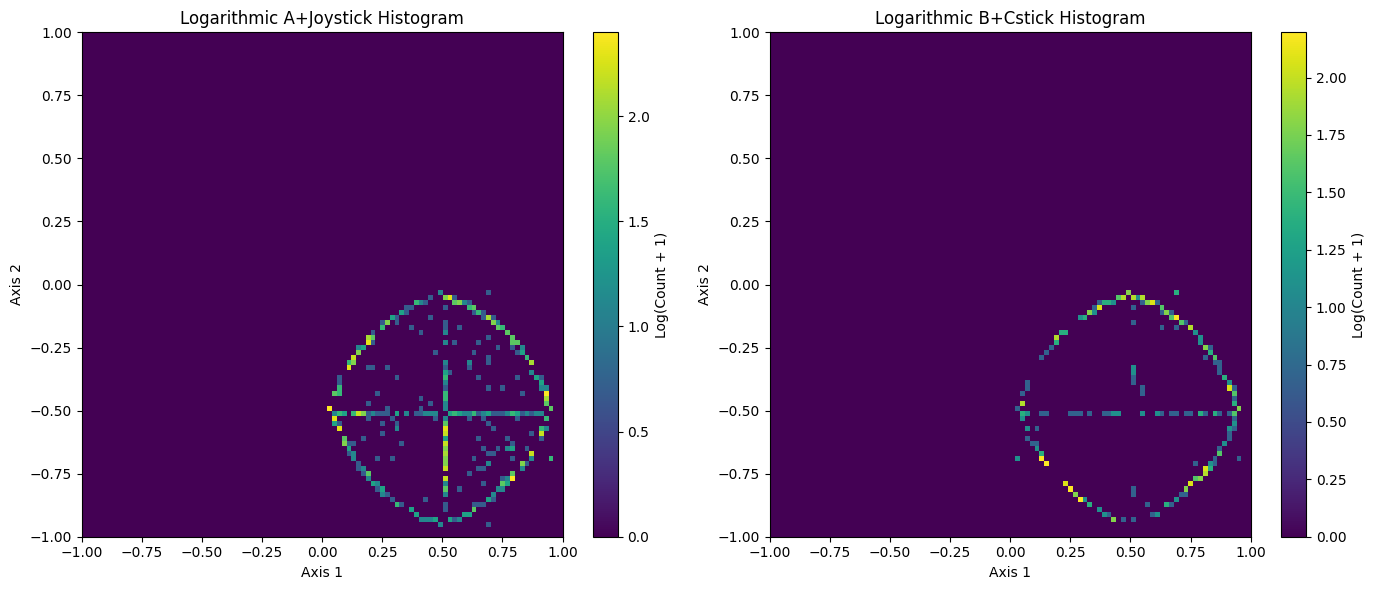

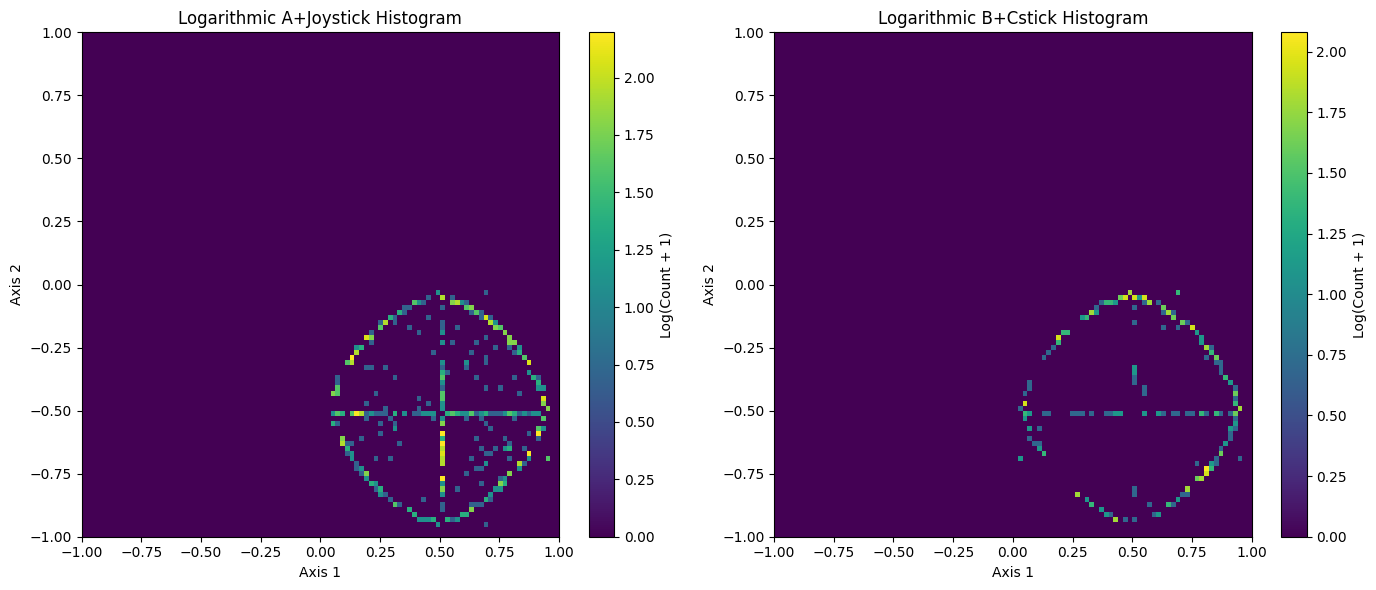

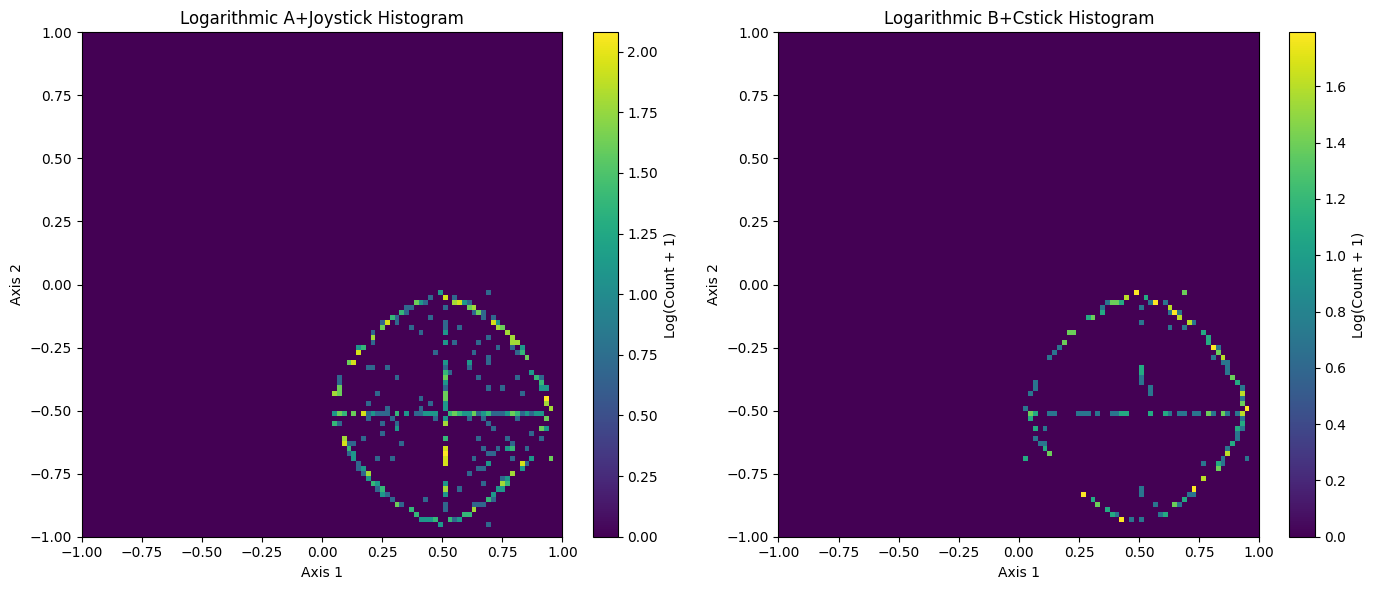

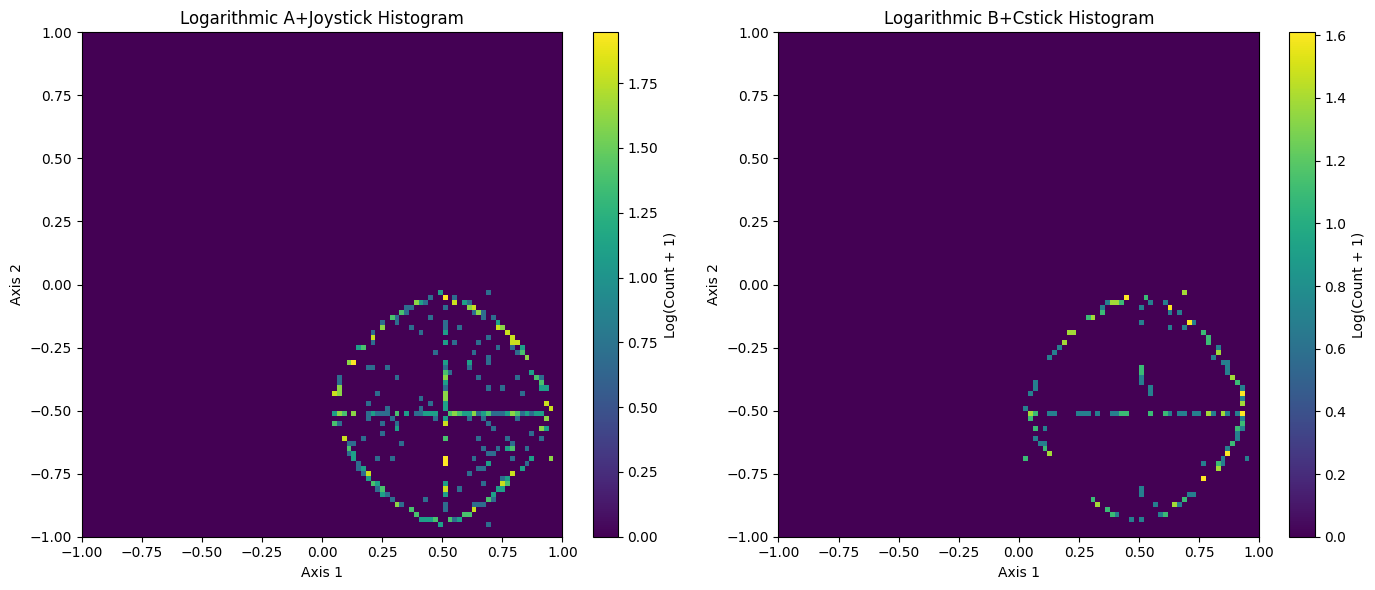

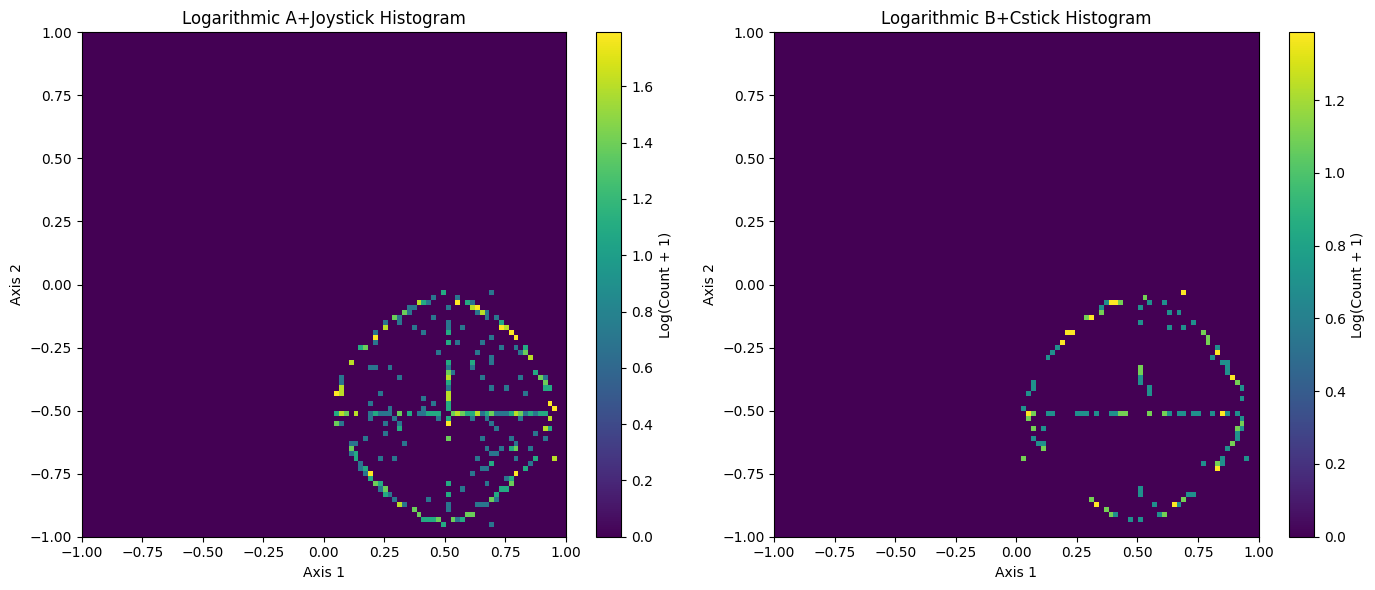

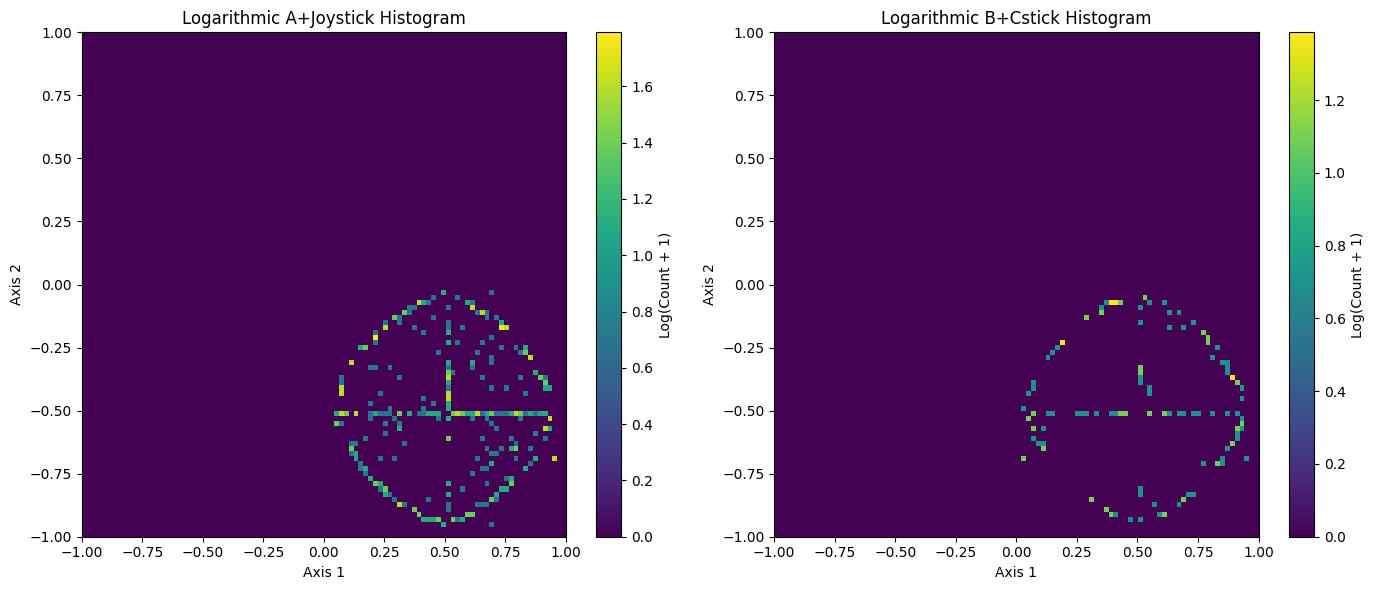

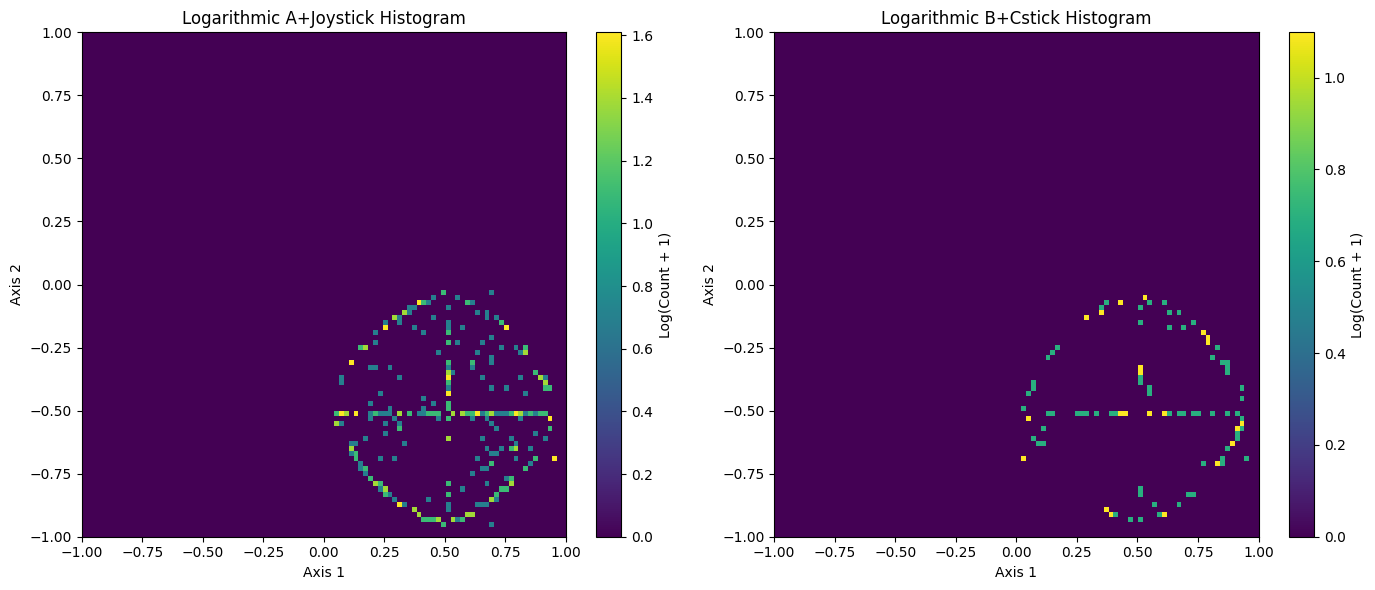

In [11]:


def load_and_update_histogram(path, jstick_histogram, cstick_histogram, nbins):
    with gzip.open(path, 'rb') as f:
        inputs = np.load(f)
    
    # Correcting the shift and scaling logic
    # Shift inputs: adjusting so that positives are reduced and negatives are increased
    analog_transformed = np.copy(inputs[0:4])
    analog_transformed[analog_transformed > 0] -= 0.2875 + 0.0125
    analog_transformed[analog_transformed < 0] += 0.2875 - 0.0125
    analog_transformed *= 0.5 / 0.725
    analog_transformed += 0.5

    # # Scale inputs to be between -1 and 1
    inputs[0:4, :] = analog_transformed

    # Update histograms
    j_hist, _, _ = np.histogram2d(inputs[1, :] * inputs[-3,:], inputs[0, :] * inputs[-3,:], bins=nbins, range=[(-1, 1), (-1, 1)])
    c_hist, _, _ = np.histogram2d(inputs[1, :] * inputs[-2,:], inputs[0, :] * inputs[-2,:], bins=nbins, range=[(-1, 1), (-1, 1)])
    
    jstick_histogram += j_hist
    cstick_histogram += c_hist

# Sample initialization and usage
sample_df = df.sample(n=1000, random_state=42)
nbins = 100
jstick_histogram = np.zeros((nbins, nbins), dtype=np.float64)
cstick_histogram = np.zeros((nbins, nbins), dtype=np.float64)

# Assuming 'paths' is a list of file paths to process
for i in range(10):
    path = '/workspace/melee_project_data/input_np/' + sample_df['player_inputs_np_sub_path'].iloc[i].replace('\\', '/')
    load_and_update_histogram(path, jstick_histogram, cstick_histogram, nbins)


def remove_populous_bins(histogram, n):
    # Flatten the histogram to work with 1D array of bins
    flat_histogram = histogram.flatten()
    
    # Find the indices of the n most populous bins
    indices_to_remove = np.argpartition(flat_histogram, -n)[-n:]
    
    # Set these bins' values to zero or minimal value
    flat_histogram[indices_to_remove] = 0
    # Optionally, set to the minimal non-zero value found in original histogram
    # min_value = np.min(flat_histogram[np.nonzero(flat_histogram)])
    # flat_histogram[indices_to_remove] = min_value

    # Reshape back to the original histogram shape
    return flat_histogram.reshape(histogram.shape)


def plot_log_histograms(jstick_histogram, cstick_histogram, nbins, n_remove):
    # Remove the n most populous bins
    jstick_histogram = remove_populous_bins(jstick_histogram, n_remove)
    cstick_histogram = remove_populous_bins(cstick_histogram, n_remove)
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
    # Prepare data for logarithmic scale
    log_jstick_histogram = jstick_histogram
    log_cstick_histogram = cstick_histogram
    log_jstick_histogram = np.log(jstick_histogram + 1)  # Add 1 to avoid log(0)
    log_cstick_histogram = np.log(cstick_histogram + 1)  # Add 1 to avoid log(0)

    # Joystick histogram
    im = axs[0].imshow(log_jstick_histogram, interpolation='nearest', origin='upper',
                        extent=[-1, 1, -1, 1], aspect='auto', cmap='viridis')
    axs[0].set_title('Logarithmic A+Joystick Histogram')
    axs[0].set_xlabel('Axis 1')
    axs[0].set_ylabel('Axis 2')
    plt.colorbar(im, ax=axs[0], label='Log(Count + 1)')

    # C-stick histogram
    im = axs[1].imshow(log_cstick_histogram, interpolation='nearest', origin='upper',
                        extent=[-1, 1, -1, 1], aspect='auto', cmap='viridis')
    axs[1].set_title('Logarithmic B+Cstick Histogram')
    axs[1].set_xlabel('Axis 1')
    axs[1].set_ylabel('Axis 2')
    plt.colorbar(im, ax=axs[1], label='Log(Count + 1)')

    plt.tight_layout()
    plt.show()

# Assuming your histograms are ready
nbins = 100
n_remove = 10 # Number of populous bins to remove
# Assuming your histograms are ready
nbins = 100
n_remove = 10 # Number of populous bins to remove

for n in range(0,10):
    plot_log_histograms(jstick_histogram, cstick_histogram, nbins, n * n_remove + 1)


### Other interesting things
It is interesting to see the stick heatmaps for different characters and compare them. It is also interesting to see what the stick postions are when the A or B buttons are being pressed for different characters. This allows us to see the difference between the characters useful moves.